# Análisis de señales electroencefalografía(EEG) y magnetoencefalografía (MEG) usando la librería MNE
&emsp;&emsp;&emsp;&emsp;**Basado en el tutorial introductorio de MNE: [Overwiev of MEG/EEG analysis with MNE-Python](https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-py)**

## Breve resumen de los EEG.
Las señales de EEG pueden ser vistas como series en función de tiempo, ya que miden actividad cerebral en un periodo específico. Estas señales usan dispositivos compuestos de electrodos colocados en el cuero cabelludo, que son representados como **canales** en un montaje.

## MNE
**MNE** es una librería que contiene útiles herramientas y algoritmos que pueden ser usados para analizar facilmente grabaciones de EEG y MEG. Este tutorial repasa brevemente el núcleo de las estructura de datos de MNE: *Raw*, *Epochs*, *Evoked* y *SourceEstimate*.

### 1. Instalación e importación de los modulos necesarios.
**MNE** puede ser facilmente instalando a través de consola con el comando `pip install`. Adicionalmente, necesitaremos la librería **Numpy**, necesario para el uso de vectores, matrices y demás funciones matemáticas útiles; así como **Matplotlib**, **Sklearn** y **PyQt5**, necesarios para ciertas funciones de MNE.


In [1]:
%pip install mne
%pip install numpy
%pip install matplotlib
%pip install sckit-learn
%pip install PyQt5

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sckit-learn (from versions: none)
ERROR: No matching distribution found for sckit-learn


Estas librerias deben ser importadas para su uso, además de la librería os

In [2]:
import numpy as np
import mne
import os

### 2. Carga de datos.
La estructura de datos de MNE esta basado en el formato *.fif* de *Neuromag*, pero hay funciones de lectura para una gran cantidad de formatos tanto de EEG como de MEG (más información en [Implementation details, Supported data formats](https://mne.tools/stable/documentation/implementation.html#data-formats)). Para este ejemplo cargaremos uno de los datasets que brinda MNE publicamente en [Datasets Overview](https://mne.tools/stable/documentation/datasets.html#sample-dataset), en este caso, *Sample*, que contiene datos de EEG y MEG de un sujeto realizando un experimento audiovisual, así como una imagen por resonancia magnética (MRI) estructural.

**Nota:** El tiempo de descarga puede ser un poco largo, dependiendo de nuestra conexión a internet (alrededor de unos 10 minutos)

In [3]:
sample_data_folder = mne.datasets.sample.data_path() # Esta función descarga el dataset en tu carpeta de
# usuario. Si ya lo tienes descargado, no lo vuelve a descargar
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True) # preload=True permite manipulación de datos
# más rápida, a costa de consumir mas memoria 

Opening raw data file C:\Users\J-Est\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


**Nota:** Si tienes el error `ImportError: DLL load failed while importan _cext` puede ser solucionado usando `py -m pip install msvc-runtime` en consola o en la siguiente linea de código:

In [4]:
%pip install msvc-runtime

### 3. Obteniendo información.

Predeterminadamente, `read_raw_fif` proporciona algo de información sobre el archivo que se lee, en nuestro ejemplo menciona la presencia de 3 *items de proyección*, estos son **Source Space Projections (SSP)**, calculados para remover ruido ambiental, así como un item para el punto de referencia medio para los canales de EEG. Adicionalmente, podemos observar los detalles basicos de un objeto `Raw` imprimiendolo con el comando `print()`, o aún más imprimiendo su atributo `info`(un objeto tipo diccionario, preservado tanto en objetos `Raw`, `Epochs` y `Evoked`).

Podemos encontrar mas información de este útil atributo en [The info data structure](https://mne.tools/stable/auto_tutorials/intro/30_info.html#tut-info-class).

In [5]:
print('Imprimiendo el objeto Raw: \n', raw)
print('\nImprimiendo su atributo info: \n', raw.info)

Imprimiendo el objeto Raw: 
 <Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.7 MB, data loaded>

Imprimiendo su atributo info: 
 <Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>


Podemos notar con la entrada `chs` que MNE es capaz de detectar y manejar diferente tipo de sensores (gradiometros, magnetómetros, electrodos de EEG...)



### 4. Plotear los datos.
Los objetos `Raw` tienen varias herramientas de ploteo incorporadas, entre ellas `compute_psd`, que nos mostrará la Densidad Espectral de Poder (PSD) o de Amplitud (ASD), que es la raiz cuadrada de la PSD.

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


c:\Users\J-Est\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


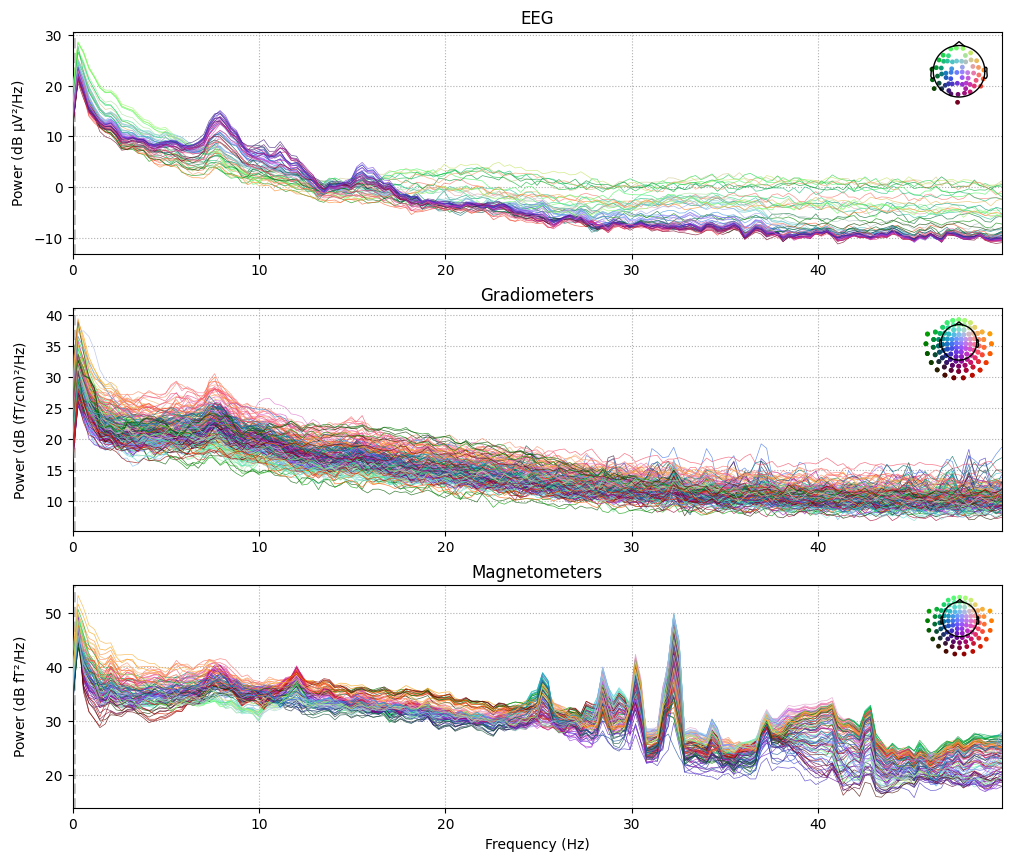

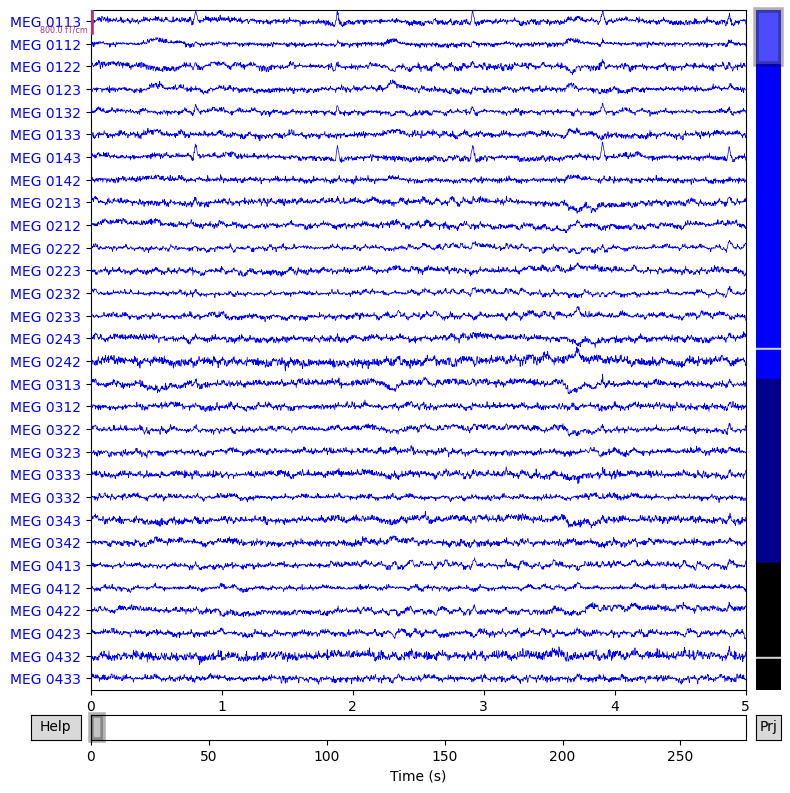

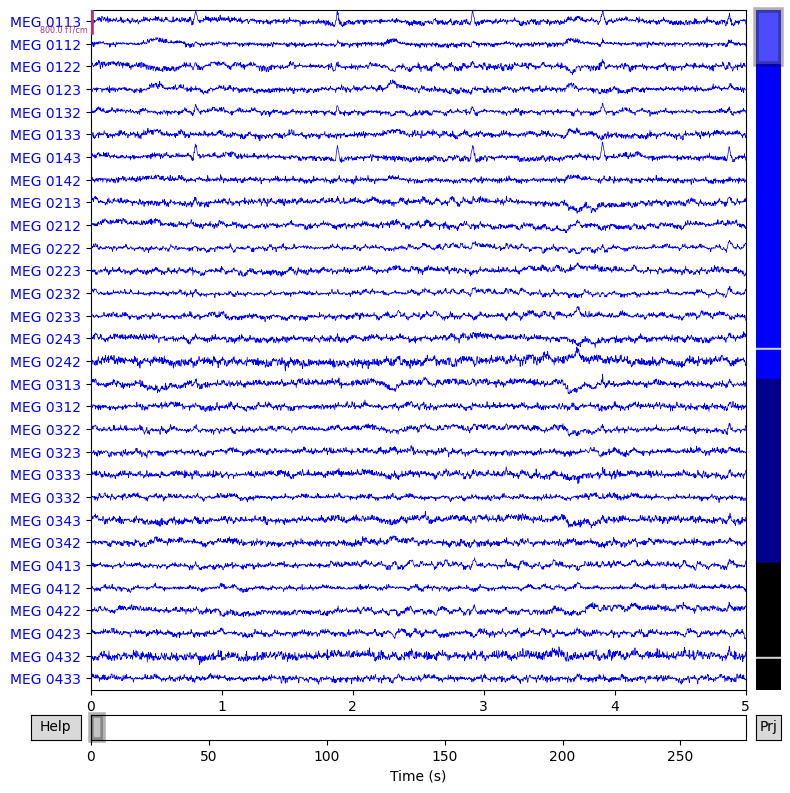

In [6]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
# Solo plotearemos frecuencias hasta 50, debido a que la data posee un filtro pasabajas a 40Hz
# El parámetro amplitude=False nos permite ver el PSD, que es el que es más comunmente usado
raw.plot(duration=5, n_channels=30)

### 5. Preprocesamiento.
MNE permite una variedad de técnicas de preprocesamiento (filtrado de Maxwell, signal-space projection, análisis de componentes independientes(ICA)...) (Podemos saber más de esto estudiando los submódulos `mne.preprocessing` y `mne.filter`). Aquí usaremos un ICA, pero no ahondaremos mucho en como se determinó los componentes que mejor capturan los artefactos.

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 34.9s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


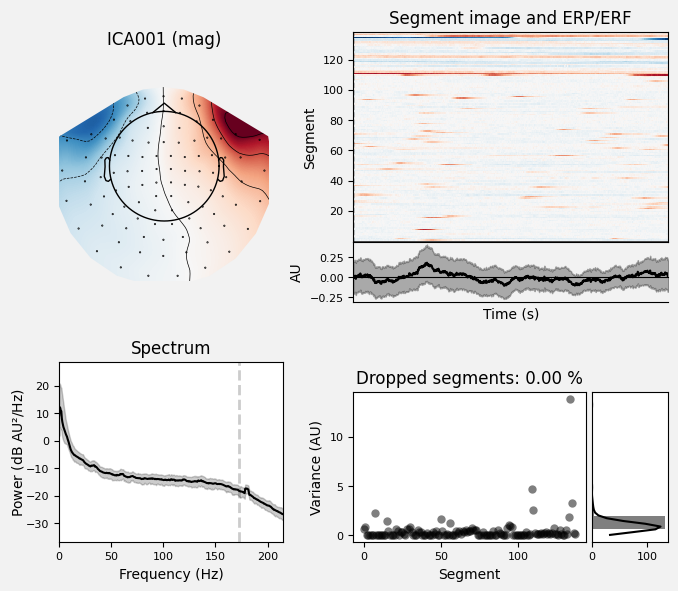

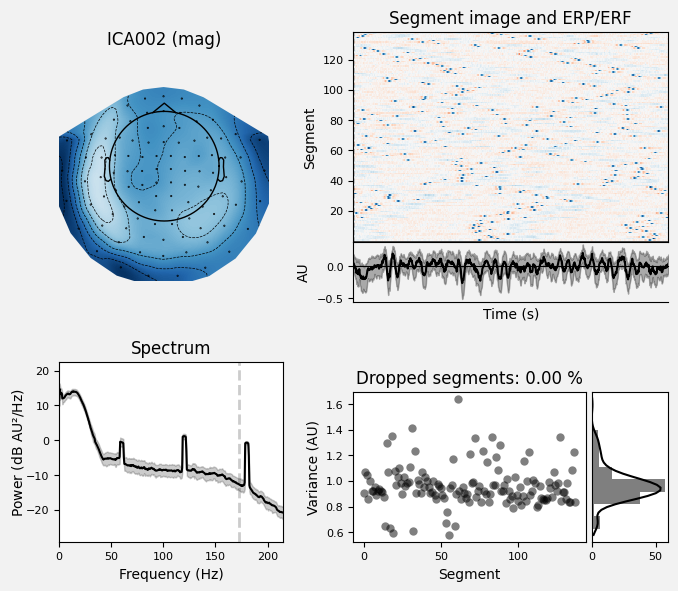

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [7]:
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # Por ahora, omitiremos por que se excluyen estos componentes
ica.plot_properties(raw, picks=ica.exclude)

Una vez estamos seguros de los componentes a remover, los pasamos por el parámetro `exclude` y aplicamos el ICA a la señal `raw`. Esto último se logra con el método `apply` y requiere que `raw` esté cargado en memoría, para lo cual usamos `load_data`.

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


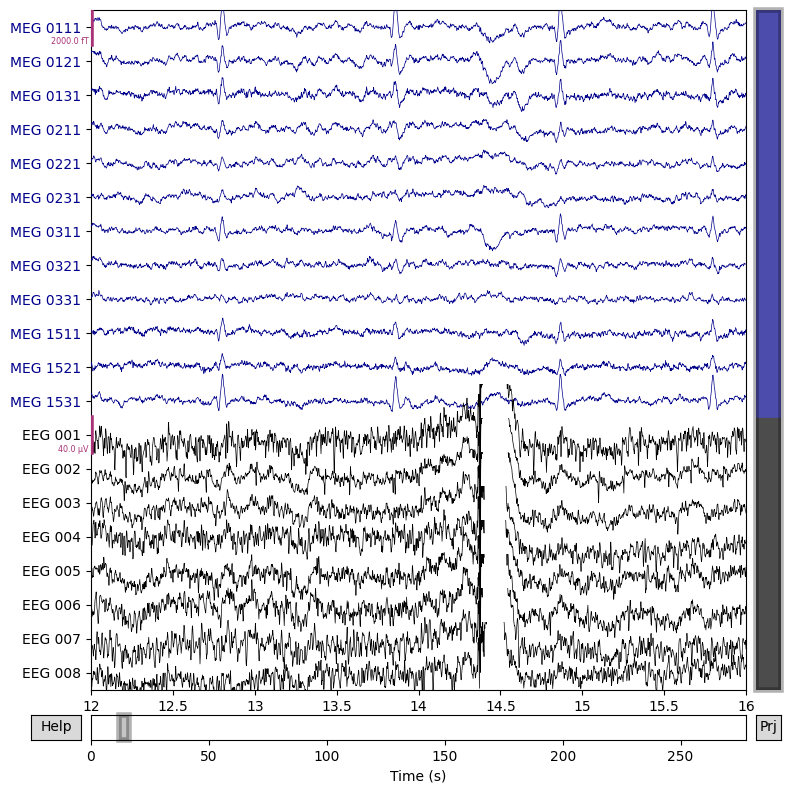

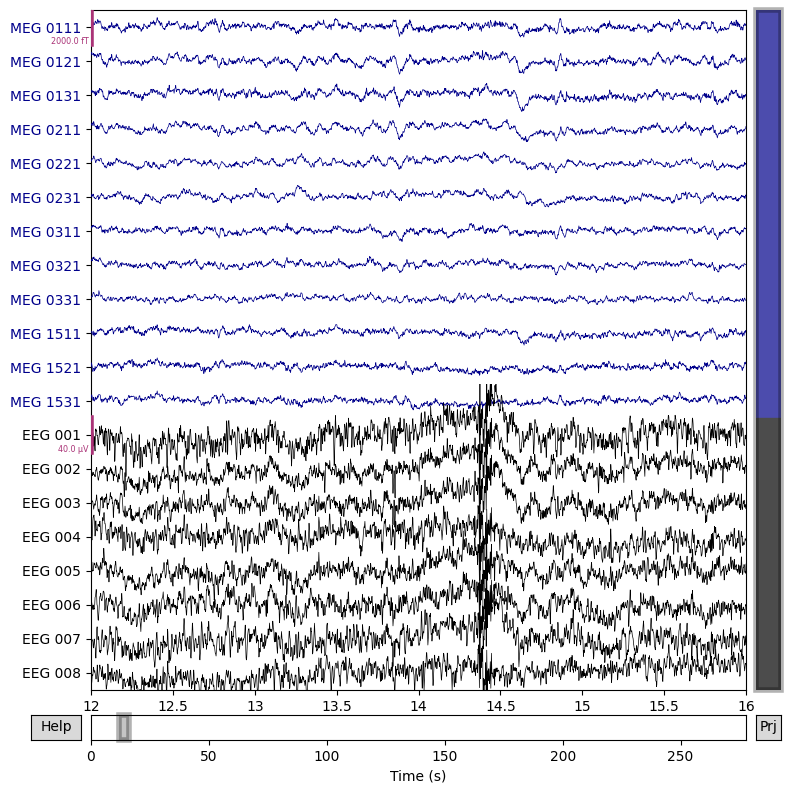

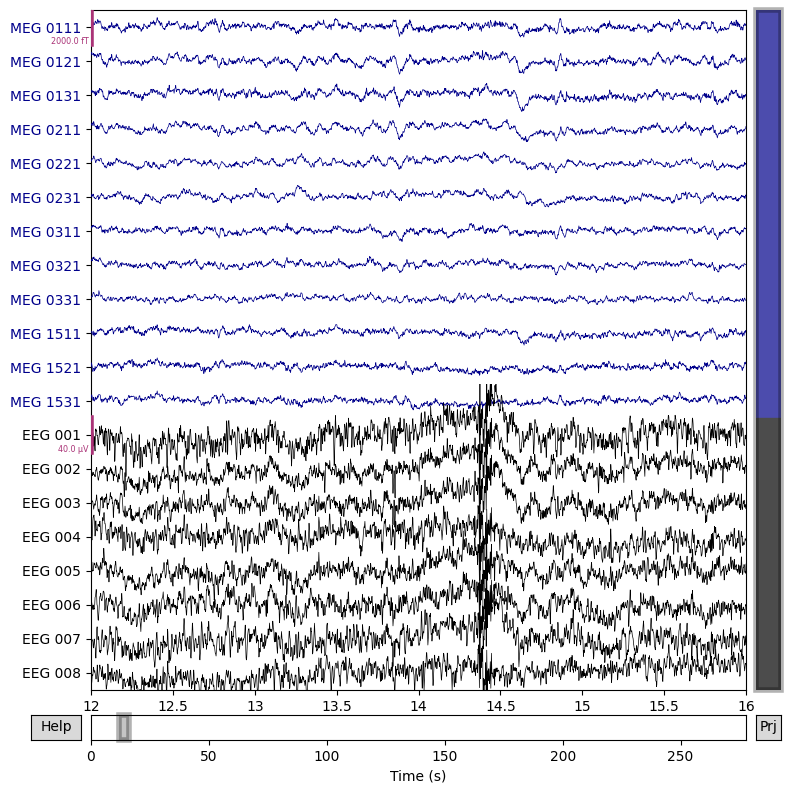

In [8]:
orig_raw = raw.copy() # Hacemos una copia de la data original para comparar antes y después de quitar los componentes
raw.load_data()
ica.apply(raw)

# Mostremos algunos canales frontales para ilustrar el efecto de quitar los artefactos
chs = [
    "MEG 0111",
    "MEG 0121",
    "MEG 0131",
    "MEG 0211",
    "MEG 0221",
    "MEG 0231",
    "MEG 0311",
    "MEG 0321",
    "MEG 0331",
    "MEG 1511",
    "MEG 1521",
    "MEG 1531",
    "EEG 001",
    "EEG 002",
    "EEG 003",
    "EEG 004",
    "EEG 005",
    "EEG 006",
    "EEG 007",
    "EEG 008",
]

chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

### 6. Detectando eventos experimentales.
El dataset de ejemplo incluye varios canales de estímulos o **STIM**, que grabaron señales eléctricas enviadas desde el computador que enviaba los estímulos. Estos pulsos o *triggers* son usados en este dataset para marcar eventos experimentales (Inicio del estímulo, tipo de estímulo y respuesta del participante). Los canales STIM individuales se combinan en uno solo, de tal manera que los niveles de voltaje de este pueden ser decodificados como un evento particular. En antiguos sistemas Neuromag (como el que se usó para este dataset) este canal se llama `STI 014`, y lo podemos pasar por la función `mne.find_events` para recoger el tiempo e identidad de los eventos de estímulo.

In [9]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5]) # Imprimimos los primeros 5 eventos

320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


El vector o *array* resultante posee 3 columnas, con el número de muestra en la primera columna y un entero de ID en la última. Usualmente, se ignora la columna del medio. Para identificar los IDs, crearemos un *diccionario de eventos* que asigne una condición experimental a cada ID. En este dataset, ese diccionario sería el siguiente.

In [10]:
event_dict = {
    "auditivo/izquierdo": 1,
    "auditivo/derecho": 2,
    "visual/izquierdo": 3,
    "visual/derecho": 4,
    "respuesta": 32
}

Diccionarios de eventos como este son usados para extraer **épocas** de data continua. El caracter `/` en las llaves del diccionario permite agrupar por condiciones al llamar descripciones parciales (Por ejemplo, llamar la condición `auditivo` devolverá las épocas con IDs 1 y 2; llamar `izquierdo` traera los de IDs 1 y 3).

Además, tenemos la función `plot events` para visualizar la distribución de eventos a lo largo de la duración de la sesión.

C:\Users\J-Est\AppData\Local\Temp\ipykernel_8680\3885976661.py:1: RuntimeWarning: event 5 missing from event_id will be ignored
  fig = mne.viz.plot_events(


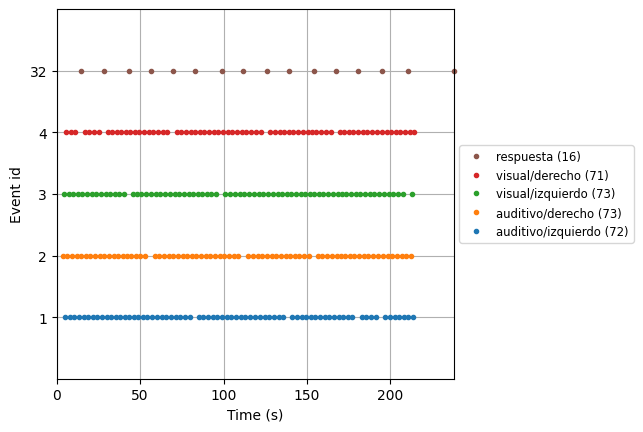

In [11]:
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
# Se uso el objeto info para obtener la frecuencia de muestreo, de modo que nuestro eje x será en segundos
# y no en samples.

Para paradigmas de toma de datos no relacionadas con eventos (Por ejemplo, toma de datos en reposo), se pueden extraer intervalos de datos regularmente espaciados (posiblemente superpuestos) al crear eventos usando `mne.make_fixed_lengt_events` y entonces proceder con la **segmentación de épocas** como se describe a continuación.

### 7. Segmentación de épocas (*epoching*) de datos continuos.
El objeto `Raw` y el array de eventos es lo mínimo requerido para crear un objeto `Epochs`, que se puede crear a partir de su  respectivo contructor de clase. Además, añadiremos ciertas limitaciones para conservar la calidad de los datos: Rechazaramos cualquier época donde la amplitud entre picos de la señal está mas allá de los límites razonables para ese tipo de canal. Esto se logra con un **Diccionario de exclusión**, en el cual podemos incluir u omitir límites para cualquiera de los tipos de canales presentes en tu data.  

**Nota:** Los valores aqui usados son para este dataset particular, ya que pueden variar segun el hardware y las condiciones presentes en el momento de su toma. Para un análisis mas automático, se puede considerar el [Autoreject package](http://autoreject.github.io/)

In [12]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13, # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,  # 250 µV
)  

Este diccionar será usado en el parametro `event_id` de la función. Además, especificaremos el `tmin` y `tmax`, que son el tiempo relativo a cada evento en el cual iniciar y finalizar cada época. Predeterminadamente, se usa -0.2 y 0.5 respectivamente, por lo que se anlizan desde 0.2 segundos antes del evento hasta 0.5 segundos después.

Finalmente, el parámetro `preload=True` nos permite precargar los datos en memoría.

In [13]:
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)

Not setting metadata
305 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 305 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 004', 'EEG 005', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 015', 'EEG 019', 'EEG 022', 'EEG 027']
    Rejecting  epoch based on EEG : ['EEG 004', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 015', 'EEG 016', 'EEG 018', 'EEG 019', 'EEG 022', 'EEG 036']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based 

Ahora agruparemos los estímulos entre izquierdos y derechos para comparar respuestas visuales y auditivas. Para tener un análisis imparcial respecto a los lados izquierdo y derecho, usaremos `equalize_event_counts` primero para samplear aleatoriamente épocas de cada condición y así ambas tengan el mismo número de épocas, coincidente con el número presente en la condición con menos cantidad de épocas buenas.

In [14]:
conds_we_care_about = ["auditivo/izquierdo", "auditivo/derecho", "visual/izquierdo", "visual/derecho"]
epochs.equalize_event_counts(conds_we_care_about)  
aud_epochs = epochs["auditivo"]
vis_epochs = epochs["visual"]
del raw, epochs  # Para liberar memoria

Dropped 12 epochs: 115, 176, 183, 185, 190, 191, 241, 244, 252, 254, 255, 258


Los objetos `Epochs` también poseen sus funciones para plotear, siendo una `plot_image`, el cual muestra cada época como una fila en una imagen, con colores representando la magnitud de la señal. La respuesta promedio evocada y la ubicación de los sensores se encuentran debajo de la imagen

Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated


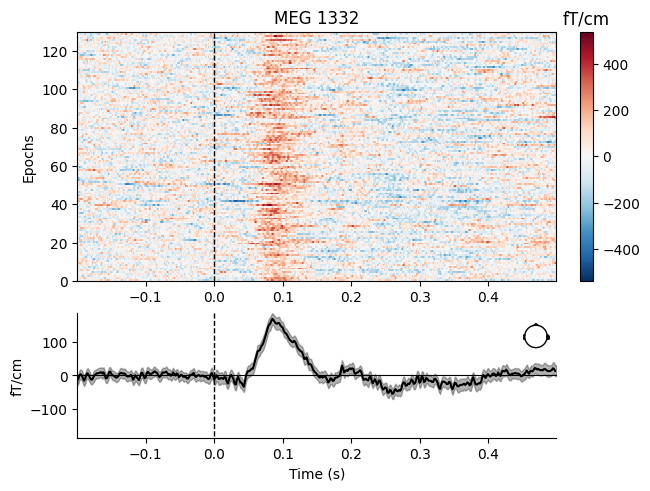

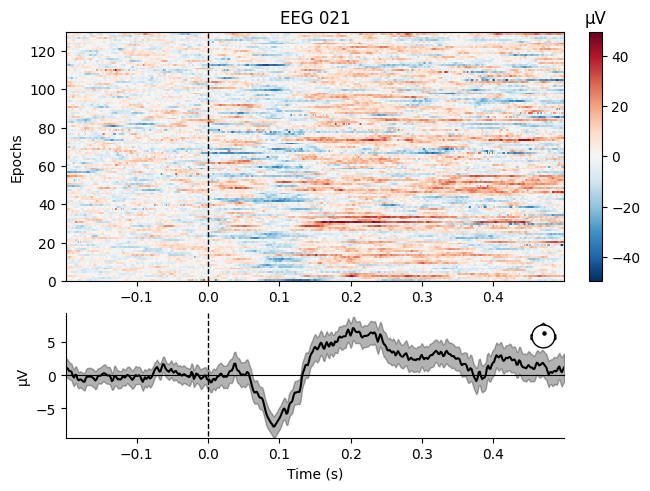

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [15]:
aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

### 8. Análisis de tiempo y frecuencia.
El submódulo `mne.time_frequency` permite implementar multiples algoritmos para computar representaciones de tiempo y frencuencia, PSD y densidad espectral cruzada (CSD). En este ejemplo computaremos el poder inducido en diferentes momentos y frecuencias para las épocas auditivas, usando **wavelets** de Morlet. Lamentablemente, el ejemplo no es especialmente informativo, como si lo sería en un dataset con alto contenido respecto a frecuencias. Aquí podemos ver el potencial evocado **N100**, que aparece tipicamente entre 80 y 120 ms luego de un estímulo.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.1s


No baseline correction applied


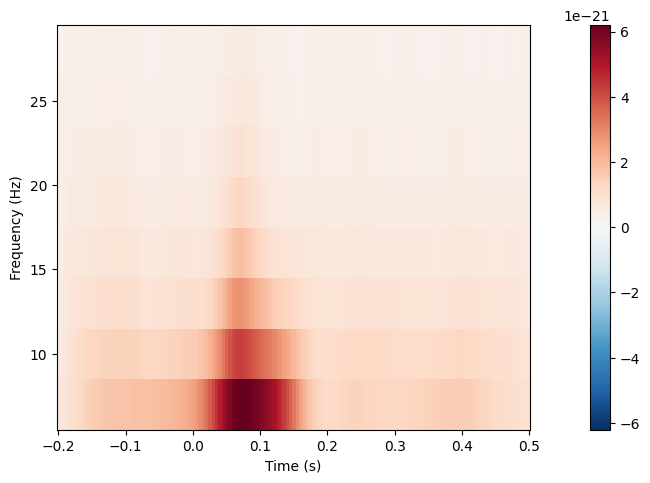

[<Figure size 640x480 with 2 Axes>]

In [16]:
frequencies = np.arange(7, 30, 3)
power = aud_epochs.compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power.plot(["MEG 1332"])

### 9. Estimando respuestas evocadas.
Ahora que tenemos nuestras condiciones en `aud_epochs` y `vis_epochs`, podemos obtener un estimado de respuestas evocadas de estimulos auditivos vs visuales al promediar juntas las épocas en cada condición. Simplemente llamamos el método `average` en el objeto `Epochs`, y usaremos una función del módulo `mne.viz` para comparar el poder de campo global (Global Field Power o GFP) para cada tipo de sensor de los dos objetos `Evoked`.

Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


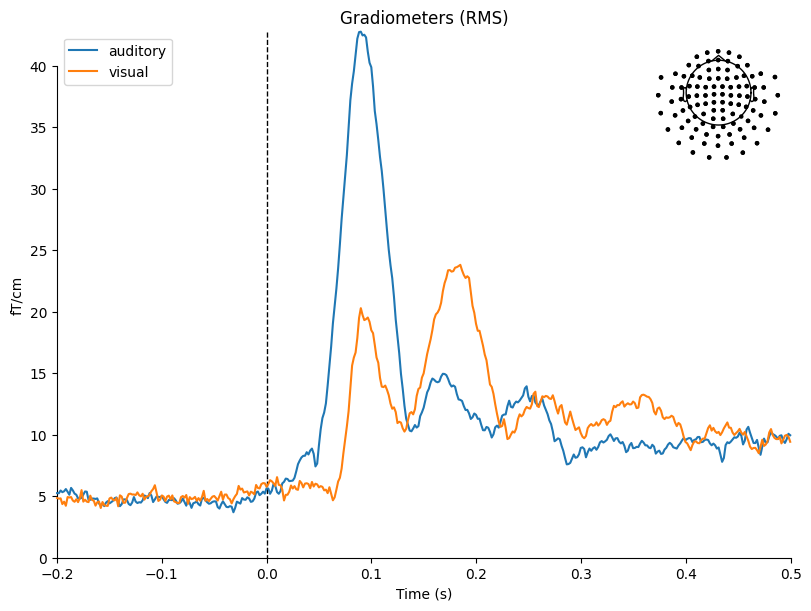

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


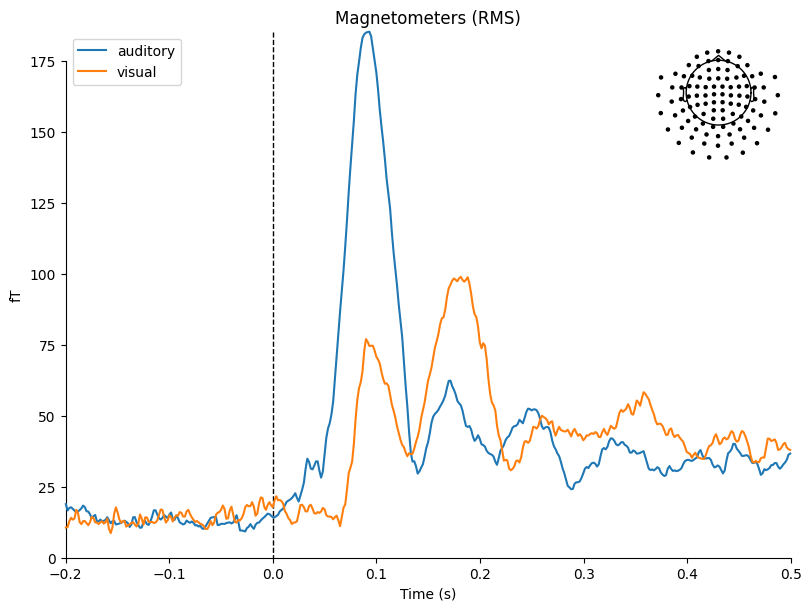

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


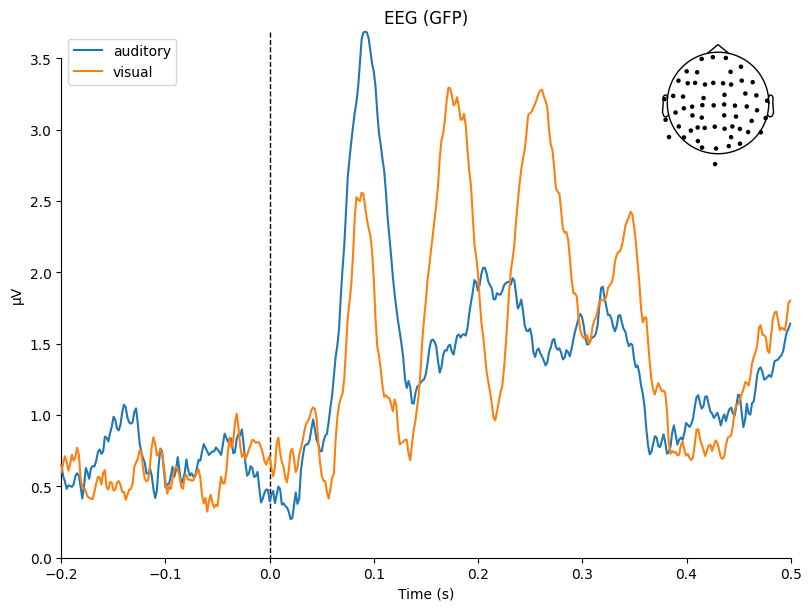

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [17]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left",
    show_sensors="upper right",
)

También podemos obtener vistas mas detallas de cada objeto `Evoked` usando otros métodos de ploteo como `plot_joint` o `plot_topomap`. Aquí examinaremos los canales de EEG para ver el patrón de la ya mencionada evocación **N100-P200** en los electrodos frontales y centrales, y también unas topografías del cuero cabelludo en tiempos arbitrarios

Projections have already been applied. Setting proj attribute to True.


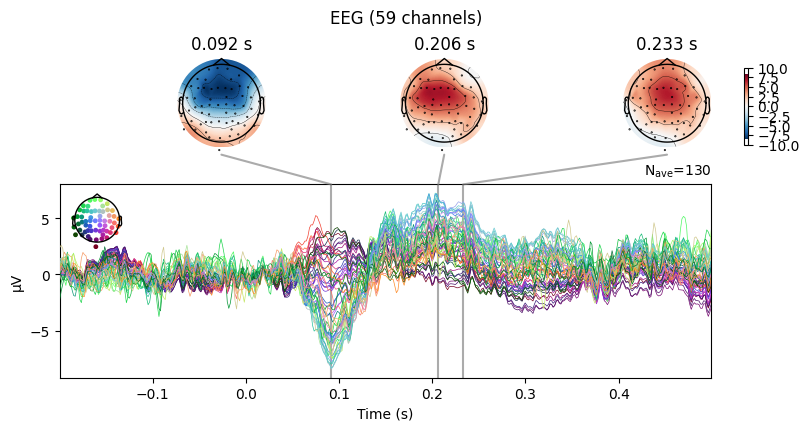

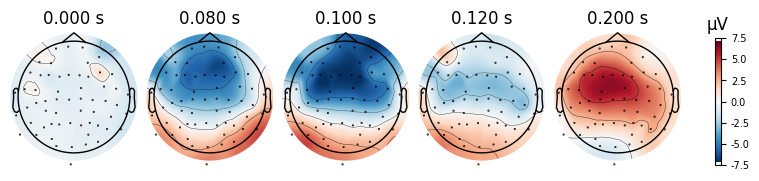

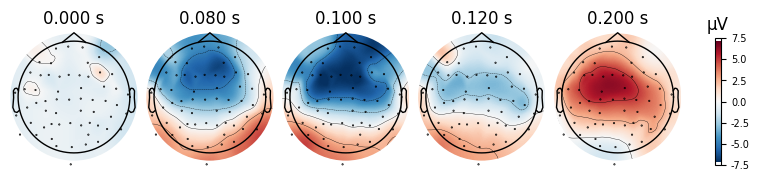

In [18]:
aud_evoked.plot_joint(picks="eeg")
aud_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

Los objetos `Evoked` pueden ser combinados para mostrar contraste entre condiciones, usando la función `mne.combine_evoked`. Una diferencia simple se puede generar pasando el parámetro `weights=[1, -1]`, luego, plotearemos la onda de diferencia en cada sensor usando `plot_topo`.

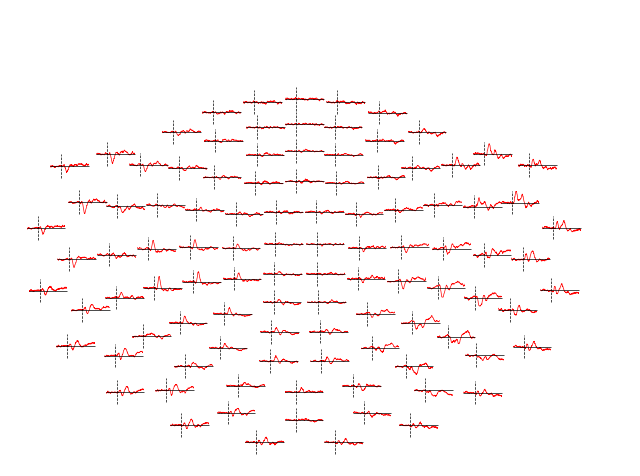

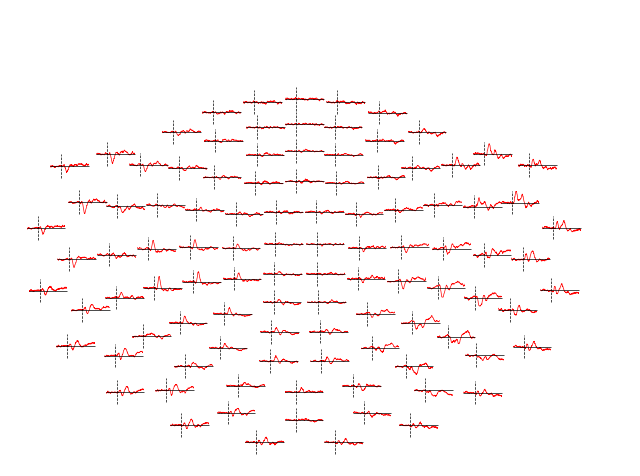

In [19]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick(picks="mag").plot_topo(color="r", legend=False)

### 10. Modelado inverso.
Finalmente, podemos estimar el origen de la actividad evocada proyectando la data de los sensores en el espacio fuente (o source space) del sujeto (un conjunto de puntos ya sea en la corteza o en el volumen cortical del sujeto, estimado a partir de escaneos de MRI). MNE brinda muchas maneras de hacer esto. En este ejemplo, usaremos la estimación de norma mínima o **minimum-norm estimation (MNE**, no confundir con la librería que estamos practicando) para generar un mapa de activación continuo limitado a la superficie cortical. La estimación utiliza un operador linear inverso para proyectar las medidas de los sensores de EEG y MEG en el source space. El operador inverso es computado de la **forward solution**(un operador lineal que captura la relación entre la ubicación de cada dipolo en el source space y su correspondiente distribución medida por los sensores) y un estimado de la covarianza de la medida de los sensores. 

Para este tutorial, nos saltaremos la mencionada computacion y cargaremos un operador inverso pre-computado incluido con nuestra descarga. Como este problema inverso está indeterminado (no hay una solución única), limitaremos la solución brindando un parametro regularizador que especifica el suavizado relativo de las corrientes estimadas en terminos del balance señal / ruido (este ruido es igual a la actividad base en toda la corteza.)

In [20]:
# Cargar operador inverso
inverse_operator_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis-meg-oct-6-meg-inv.fif"
)
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# Establecer balance señal / ruido (SNR) para computar parámetro de regularización (λ²)
snr = 3.0
lambda2 = 1.0 / snr**2
# Generar el source time course (STC)
stc = mne.minimum_norm.apply_inverse(
    vis_evoked, inv_operator, lambda2=lambda2, method="MNE"
)  # o dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from C:\Users\J-Est\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing 

Para terminar, para plotear la estimación de fuentes en la corteza del sujeto, también necesitaremos la dirección a los archivos de MRI estructural del mismo (para el parámetro `subjects_dir`)

Una representación de esta reconstrucción final sería:
![Ejemplo modelo inverso](.\images\inverse_model.png)

In [21]:
# Dirección a los archivos de MRI
subjects_dir = sample_data_folder / "subjects"
# Plotear el STC
stc.plot(
    initial_time=0.1, hemi="split", views=["lat", "med"], subjects_dir=subjects_dir
)

Using pyvistaqt 3d backend.

Using control points [1.06131028e-10 1.26612309e-10 4.71416342e-10]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


**Nota:** Si tienes un error usando esta última linea en un notebook, podría ayudarnos instalar las siguientes librerias:

In [22]:
%pip install ipywidgets
%pip install pyvistaq
%pip install nibabel


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyvistaq (from versions: none)
ERROR: No matching distribution found for pyvistaq


Note: you may need to restart the kernel to use updated packages.


Using control points [1.61294160e-10 2.16836000e-10 1.16323291e-09]
Using control points [1.61294160e-10 2.16836000e-10 1.16323291e-09]


In [ ]:
# Original Authors: The MNE-Python contributors.
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.